## **Section 1: Library and Data Imports (Q1)**

- Import your libraries and read the data into a dataframe. Print the head of the dataframe. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(color_codes = True)
sns.set_palette('Pastel1')
import matplotlib.pyplot as plt
import time

In [2]:
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import levene, ttest_ind

In [3]:
train = pd.read_csv('rossmann-store-sales/train.csv')
store = pd.read_csv('rossmann-store-sales/store.csv')
train['Date'] = pd.to_datetime(train['Date'])
df = pd.merge(train, store, on = 'Store')
df.shape

(1017209, 18)

In [4]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


## **Section 2: Effect of Holidays (Q2)**

To begin with the data exploration process on the Rossmann Stores Sales, we are interested in how store sales are influenced during and before the holidays. Before doing any computation or plotting, it is essential to examine the crucial variables related to our interest. In particular, I believe variables `Open`, `StateHoliday` and `SchoolHoliday` are required for analyzing the relationship between holiday/non-holiday seasons and `Sales`. Thus, it is important to understand precisely the meaning of each variable:

> `Sales` - the turnover for any given day
>
> `Open` - an indicator for whether the store was open: 0 = closed, 1 = open
>
> `StateHoliday` - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
>
> `SchoolHoliday` - indicates if the (Store, Date) was affected by the closure of public schools

After confirming the interpretation of the variables, it is also essential to verify the data values and observe if they match our expectations.

In [5]:
df1 = df[['Sales', 'StateHoliday', 'SchoolHoliday']]
df1['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [6]:
df1[['SchoolHoliday', 'Sales']].value_counts()

SchoolHoliday  Sales
0              0        154595
1              0         18276
0              5674        175
               6214        164
               6052        160
                         ...  
               24547         1
               24542         1
               24533         1
               24530         1
1              38367         1
Length: 37090, dtype: int64

In [7]:
df1['Sales'].max()

41551

The variables `StateHoliday` and `SchoolHoliday` are encoded as categorical variables with explicit meanings, which provide a simple verification as shown above. `Sales` is a continuous variable with a minimum of 0 and a maximum of 41551. `Open` will be examined later on. Note that there are two zeros for `StateHoliday`. One of them is a numeric type and the other is a string type. Hence, I changed the 0s with a string variable type to a numeric variable type. Moreover, missing values may play a significant role in the calculation and analysis process and therefore inspection is needed.

In [8]:
df1['StateHoliday'].replace('0', 0, inplace = True)
df1.isnull().sum()

Sales            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

No missing value is found for the three variables. Therefore, we can proceed to analyze the relationship for the task. First, I investigated and visualized the store sales for different types of state holidays using boxplots. The first plot on the left shows the store sales distribution for state non-holiday seasons. The second and the third plots depict the store sales for state holiday seasons. In particular, the second boxplot considers sales only for stores having positive sales, and the other investigates store sales in general.

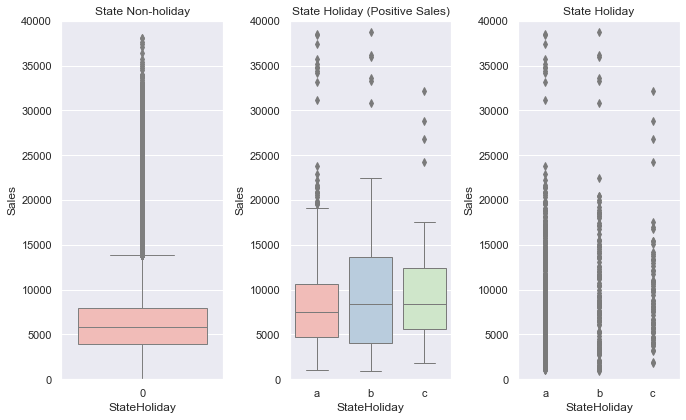

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (9.7, 6))
sns.boxplot(x = 'StateHoliday', y = 'Sales', data = df1[df1['StateHoliday'] == 0], linewidth = 1, ax = ax[0])
ax[0].set_title('State Non-holiday')
ax[0].set_ylim([0, 40000])

sns.boxplot(x = 'StateHoliday', y = 'Sales', data = df1[(df1['StateHoliday'] != 0) & (df1['Sales'] > 0)], linewidth = 1, ax = ax[1])
ax[1].set_title('State Holiday (Positive Sales)')
ax[1].set_ylim([0, 40000])

sns.boxplot(x = 'StateHoliday', y = 'Sales', data = df1[df1['StateHoliday'] != 0], linewidth = 1, ax = ax[2])
ax[2].set_title('State Holiday')
ax[2].set_ylim([0, 40000])

plt.tight_layout()

Based on the boxplots, I observed that stores with positive sales during state holidays, in general, have more sales compared to those during state non-holidays. Yet, the mean sales differences between them is not dramatic. Moreover, comparing the second and the third boxplots, we observe that most stores do not have any sales during state holidays. Hence, the analysis result matches with the description of `StateHoliday`: 

> Normally all stores, with few exceptions, are closed on state holidays. 

We can further justify the conclusion by considering the variable `Open`.

In [10]:
df1['Open'] = df['Open']
df1['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [11]:
df1['Open'].isnull().sum()

0

Note that `Open` is a binary variable without missing values. We can use the Pearson product-moment correlation coefficient to test the linear association between `StateHoliday` and `Open`. Remark that because `StateHoliday` is a categorical variable with values 0, a, b and c, cases a, b and c should be combined and denoted as 1 (state holiday) so that the correlation coefficient provides meaningful information.

In [12]:
df1['StateHoliday'].replace(['a', 'b', 'c'], 1, inplace = True)
df1['StateHoliday'].corr(df1['Open'])

-0.37837795816325975

The Pearson product-moment correlation coefficient is about -0.378. That is, stores tend to close as seasons move from a state non-holiday to a state holiday, which matches with our expectation from the boxplots. Hence, I conclude that people shop slightly more during state holidays for stores with positive sales (open stores in general). Moreover, people shop more before state holidays for stores having no sales (closed stores in general).

Using a similar procedure, I analyzed whether school holiday seasons may affect store sales.

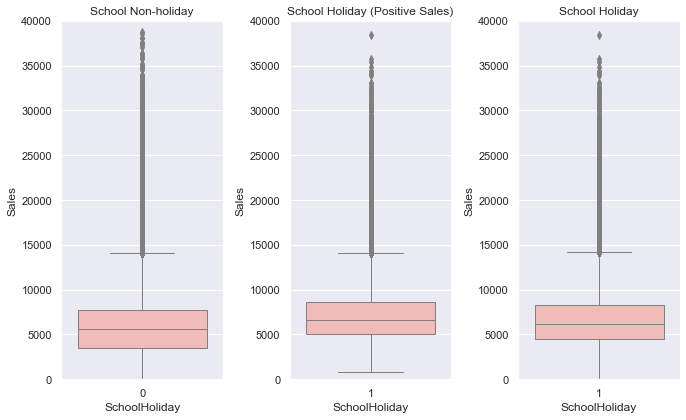

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (9.7, 6))
sns.boxplot(x = 'SchoolHoliday', y = 'Sales', data = df1[df1['SchoolHoliday'] == 0], linewidth = 1, ax = ax[0])
ax[0].set_title('School Non-holiday')
ax[0].set_ylim([0, 40000])

sns.boxplot(x = 'SchoolHoliday', y = 'Sales', data = df1[(df1['SchoolHoliday'] == 1) & (df1['Sales'] > 0)], linewidth = 1, ax = ax[1])
ax[1].set_title('School Holiday (Positive Sales)')
ax[1].set_ylim([0, 40000])

sns.boxplot(x = 'SchoolHoliday', y = 'Sales', data = df1[df1['SchoolHoliday'] != 0], linewidth = 1, ax = ax[2])
ax[2].set_title('School Holiday')
ax[2].set_ylim([0, 40000])

plt.tight_layout()

The boxplots for school holidays above show some different sales patterns than state holidays. More specifically, the boxplot of the stores affected by the closure of public schools with positive sales shows, visually speaking, the same distribution as the boxplot of the stores not affected by school holiday seasons in general appears, with a little more on the average sales. On the other hand, stores have slightly higher sales for affected stores in school holiday seasons than not affected stores. Also, as mentioned in `StateHoliday` variable description:

> Note that all schools are closed on public holidays and weekends.

Thus, given the conclusion that stores having positive sales are more likely to have increased sales during state holidays, people shop a little more during school holidays than before.

## **Section 3: Most and Least selling stores (Q3a & Q3b)**

For this task, we first select the stores having at least 6 months of sales data. I have changed the `Dates` string data type into datetime64 data type so that date time calculations become simpler. Note that the shortest 6 months is 182 days occurred in leap years. Again, we begin by looking into variable data values and missing values.

> `Store` - a unique Id for each store
>
> `Date` - the date opening

In [14]:
df['Date'].value_counts()

2015-07-31    1115
2013-11-06    1115
2013-11-18    1115
2013-11-17    1115
2013-11-16    1115
              ... 
2014-10-28     935
2014-10-27     935
2014-10-26     935
2014-10-25     935
2014-12-08     935
Name: Date, Length: 942, dtype: int64

In [15]:
df['Date'].isnull().sum()

0

In [16]:
grouped1 = df['Date'].groupby(df['Store'])
all(grouped1.apply(lambda grp: grp.max() - grp.min()) >= timedelta(days = 182))

True

Therefore, all stores have at least 6 months of sales data. Now, we can find the top and the bottom five store sales.

In [17]:
grouped2 = df['Sales'].groupby(df['Store']).sum()
grouped2.nlargest(5)

Store
262     19516842
817     17057867
562     16927322
1114    16202585
251     14896870
Name: Sales, dtype: int64

In [18]:
grouped2.nsmallest(5)

Store
307    2114322
543    2179287
198    2268273
208    2302052
263    2306075
Name: Sales, dtype: int64

The five stores with the highest cumulative sales are Store ID 262, 817, 562, 1114, and 251. The five stores with the least cumulative sales are Store ID 307, 543, 198, 208, and 263.

### Section 3(a): Sales Per Week over Time

In particular, we are interested in plotting store sales per week over time for the two sets of stores found above. Since dates only record the year, month and day of the sales data, calculating the corresponding week number of the year, call it `WeekOfYear`, helps drastically to plot the sales per week over time. To save some effort for future tasks, `Date` is extracted into three separate variables `Year`, `Month` and `Day`.

In [19]:
df['Year'] = df.Date.map(lambda x: x.year)
df['Month'] = df.Date.map(lambda x: x.month)
df['Day'] = df.Date.map(lambda x: x.day)
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

For best visualizations, I will plot a line chart for each year for each set of stores with horizontal axes labeling the week in the year.

Text(0.5, 1.0, 'Sales Per Week for the Highest Five Cumulative Stores in 2013')

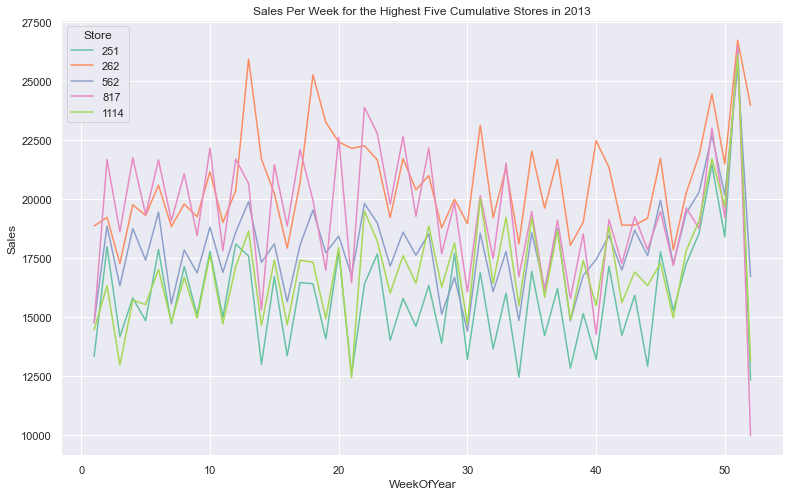

In [20]:
grouped3 = df[df['Store'].isin([262, 817, 562, 1114, 251]) & (df['Year'] == 2013)][['Store', 'Sales', 'WeekOfYear']].groupby(['Store', 'WeekOfYear']).mean().reset_index()

fig, ax = plt.subplots(figsize = (12.94, 8))
sns.lineplot(x = 'WeekOfYear', y = 'Sales', hue = 'Store', data = grouped3, palette = 'Set2')
ax.set_title('Sales Per Week for the Highest Five Cumulative Stores in 2013')

Text(0.5, 1.0, 'Sales Per Week for the Highest Five Cumulative Stores in 2014')

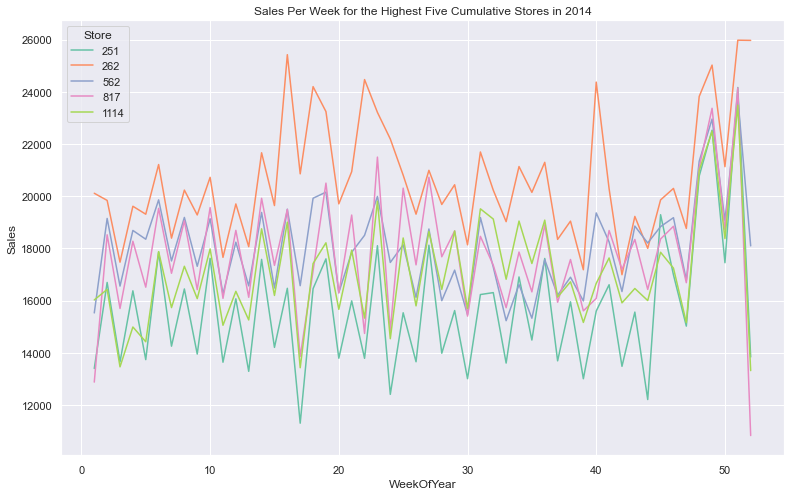

In [21]:
grouped4 = df[df['Store'].isin([262, 817, 562, 1114, 251]) & (df['Year'] == 2014)][['Store', 'Sales', 'WeekOfYear']].groupby(['Store', 'WeekOfYear']).mean().reset_index()

fig, ax = plt.subplots(figsize = (12.94, 8))
sns.lineplot(x = 'WeekOfYear', y = 'Sales', hue = 'Store', data = grouped4, palette = 'Set2')
ax.set_title('Sales Per Week for the Highest Five Cumulative Stores in 2014')

Text(0.5, 1.0, 'Sales Per Week for the Highest Five Cumulative Stores in 2015')

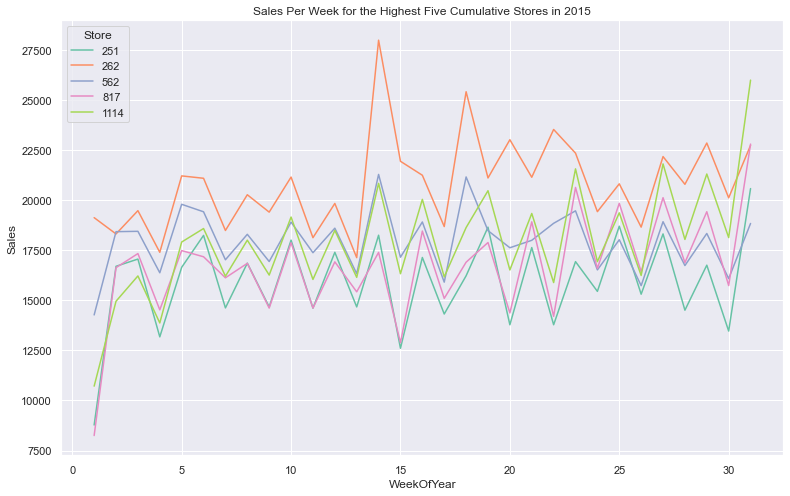

In [22]:
grouped5 = df[df['Store'].isin([262, 817, 562, 1114, 251]) & (df['Year'] == 2015)][['Store', 'Sales', 'WeekOfYear']].groupby(['Store', 'WeekOfYear']).mean().reset_index()

fig, ax = plt.subplots(figsize = (12.94, 8))
sns.lineplot(x = 'WeekOfYear', y = 'Sales', hue = 'Store', data = grouped5, palette = 'Set2')
ax.set_title('Sales Per Week for the Highest Five Cumulative Stores in 2015')

Text(0.5, 1.0, 'Sales Per Week for the Least Five Cumulative Stores in 2013')

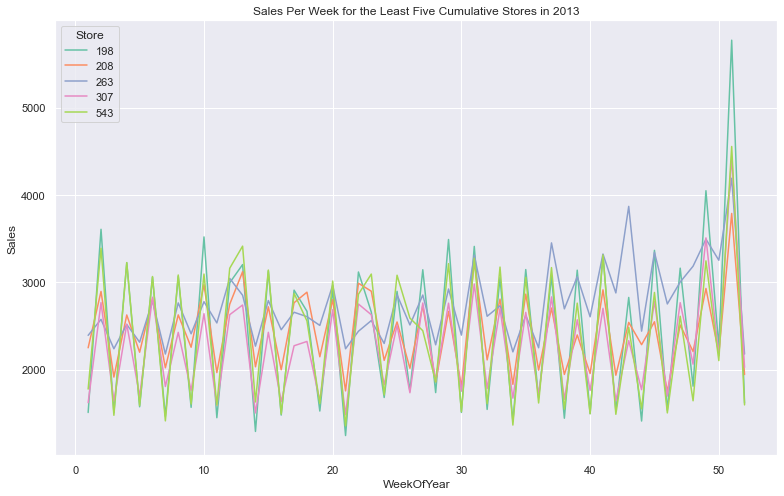

In [23]:
grouped6 = df[df['Store'].isin([307, 543, 198, 208, 263]) & (df['Year'] == 2013)][['Store', 'Sales', 'WeekOfYear']].groupby(['Store', 'WeekOfYear']).mean().reset_index()

fig, ax = plt.subplots(figsize = (12.94, 8))
sns.lineplot(x = 'WeekOfYear', y = 'Sales', hue = 'Store', data = grouped6, palette = 'Set2')
ax.set_title('Sales Per Week for the Least Five Cumulative Stores in 2013')

Text(0.5, 1.0, 'Sales Per Week for the Least Five Cumulative Stores in 2014')

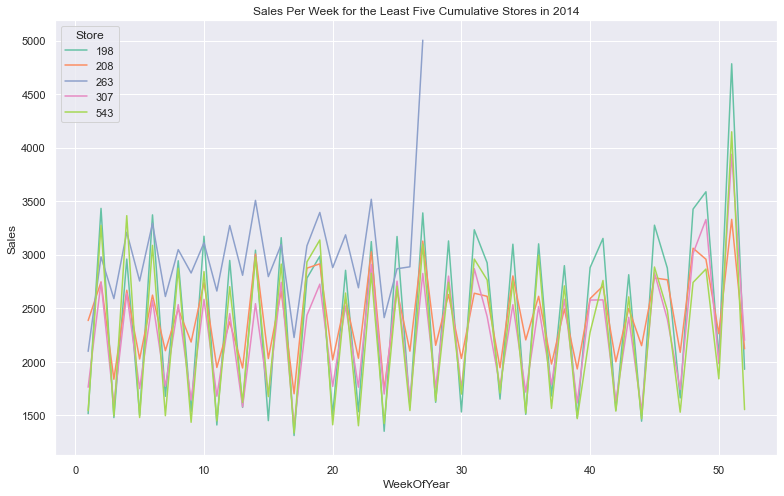

In [24]:
grouped7 = df[df['Store'].isin([307, 543, 198, 208, 263]) & (df['Year'] == 2014)][['Store', 'Sales', 'WeekOfYear']].groupby(['Store', 'WeekOfYear']).mean().reset_index()

fig, ax = plt.subplots(figsize = (12.94, 8))
sns.lineplot(x = 'WeekOfYear', y = 'Sales', hue = 'Store', data = grouped7, palette = 'Set2')
ax.set_title('Sales Per Week for the Least Five Cumulative Stores in 2014')

Text(0.5, 1.0, 'Sales Per Week for the Least Five Cumulative Stores in 2015')

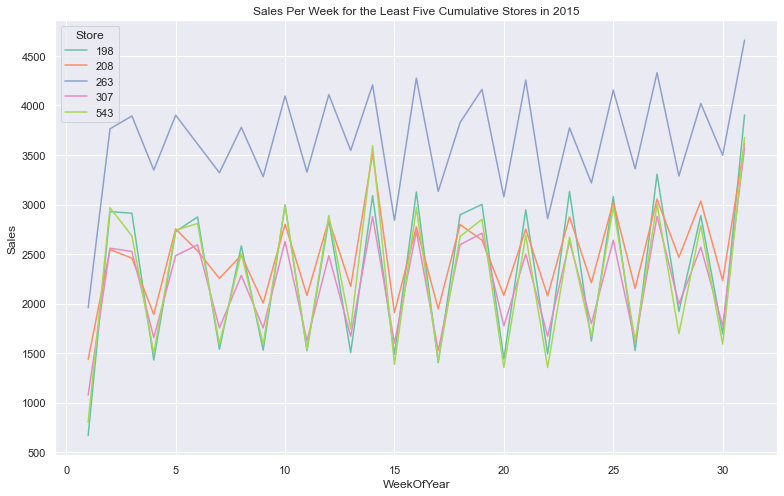

In [25]:
grouped8 = df[df['Store'].isin([307, 543, 198, 208, 263]) & (df['Year'] == 2015)][['Store', 'Sales', 'WeekOfYear']].groupby(['Store', 'WeekOfYear']).mean().reset_index()

fig, ax = plt.subplots(figsize = (12.94, 8))
sns.lineplot(x = 'WeekOfYear', y = 'Sales', hue = 'Store', data = grouped8, palette = 'Set2')
ax.set_title('Sales Per Week for the Least Five Cumulative Stores in 2015')

### Section 3(b): Patterns of Sales

Besides plotting sales per week over time for the two sets of stores, the patterns of sales are also of interest. In particular, the distributions of the two sets of store sales can be compared quantitatively by violin plots. For a better visualization for comparison, the variables are in ascending order of the cumulative sales for each set.

Text(0.5, 1.0, 'Sales Per Week for the Highest Five Cumulative Stores')

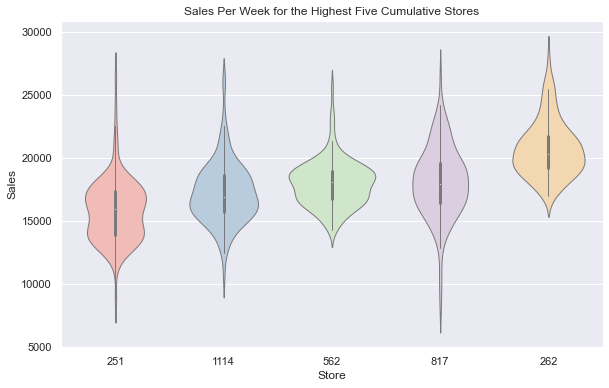

In [26]:
grouped9 = pd.concat([grouped3, grouped4, grouped5])

fig, ax = plt.subplots(figsize = (9.7, 6))
sns.violinplot(x = 'Store', y = 'Sales', data = grouped9, order = [251, 1114, 562, 817, 262], linewidth = 1)
ax.set_title('Sales Per Week for the Highest Five Cumulative Stores')

For the set of five stores with the highest cumulative sales, the distributions are all approximately normal, with some store distributions having longer tails. Unsurprisingly, the center/mean of the distributions is in increasing order.

Text(0.5, 1.0, 'Sales Per Week for the Least Five Cumulative Stores')

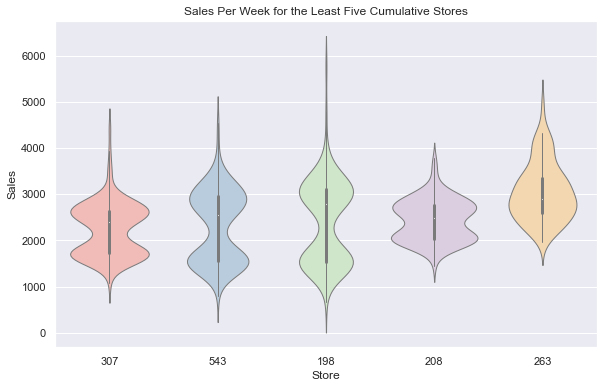

In [27]:
grouped10 = pd.concat([grouped6, grouped7, grouped8])

fig, ax = plt.subplots(figsize = (9.7, 6))
sns.violinplot(x = 'Store', y = 'Sales', data = grouped10, order = [307, 543, 198, 208, 263], linewidth = 1)
ax.set_title('Sales Per Week for the Least Five Cumulative Stores')

The violin plot of the set of five stores with the least cumulative sales describes a different picture. Especially, the distributions are bimodal except for Store ID 263. The center/mean of the distributions does not deviate much, quantitatively speaking, except that Store ID 263 has slightly higher mean sales per week.

## **Section 4: Distance of the Closest Competitor (Q4)**

In this task, I am interested in knowing whether the stores further than their closest competitors have better sales per week than the closer ones. The new variable required for this task is `CompetitionDistance`.

`CompetitionDistance` - distance in meters to the nearest competitor store

In [28]:
df2 = df[['Sales', 'CompetitionDistance', 'WeekOfYear']]
df2['CompetitionDistance'].value_counts()

250.0      11120
350.0       7536
50.0        7536
1200.0      7374
190.0       7352
           ...  
3920.0       758
4460.0       758
13090.0      758
5890.0       758
12870.0      758
Name: CompetitionDistance, Length: 654, dtype: int64

In [29]:
df2['CompetitionDistance'].isnull().sum()

2642

We first look at whether the variables of interest require data cleaning. There are 2642 missing values for `CompetitionDistance`. Because only 0.26% of the data is missing, dropping the missing value observations will not significantly impact the analysis process. We have examined the variables `Sales` and `WeekOfYear` in previous sections.

Text(0.5, 1.0, 'Sales Per Week Versus Distance of the Closest Competitor')

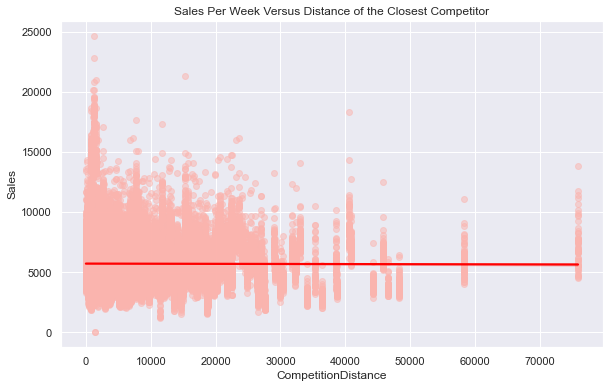

In [30]:
df2.dropna(how = 'any', inplace = True)
grouped11 = df2.groupby(['CompetitionDistance', 'WeekOfYear']).mean().reset_index()

fig, ax = plt.subplots(figsize = (9.7, 6))
sns.regplot(x = 'CompetitionDistance', y = 'Sales', data = grouped11, scatter_kws = {'alpha': 0.5}, line_kws = {"color": "red"})
ax.set_title('Sales Per Week Versus Distance of the Closest Competitor')

Given the above scatter plot with a regression line in red, since the regression line is about horizontal, we can conclude that the average sale per week is independent of the distance of the nearest competitor. In other words, the stores farther from competitors will not have a better sale per week than the closer ones.

## **Section 5: Pearson Correlation of Features (Q5)**

Here I am interested in testing the correlation coefficients between the five selected variables (including sales) to find the feature pairs with the strongest correlations. The five variables are `DayOfWeek`, `Sales`, `Customers`, `Open` and `Promo`.


> `DayOfWeek` - the day in a week (e.g. 1 corresponds to Monday and 7 corresponds to Sunday)
>
> `Customers` - the number of customers on a given day
>
> `Promo` - indicates whether a store is running a promo on that day

The data and the missing values of the three new features above need to be examined.

In [31]:
df4 = df[['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo']]
df4[['DayOfWeek', 'Customers', 'Promo']].value_counts()

DayOfWeek  Customers  Promo
7          0          0        141137
4          0          0          7755
1          0          0          6655
5          0          1          5428
4          0          1          3463
                                ...  
           1703       0             1
                      1             1
           1705       0             1
           1708       0             1
7          5145       0             1
Length: 30603, dtype: int64

In [32]:
df4[['DayOfWeek', 'Customers', 'Promo']].isnull().sum()

DayOfWeek    0
Customers    0
Promo        0
dtype: int64

Now, we can calculate the correlation matrix, and plot its heatmap for the five variables. There are many existing metrics to calculate the correlation coefficient. First, we used the Pearson product-moment correlation coefficient metric.

In [33]:
df4.corr()

,DayOfWeek,Sales,Customers,Open,Promo
DayOfWeek,1.000000,-0.462125,-0.386445,-0.528963,-0.392925
Sales,-0.462125,1.000000,0.894711,0.678472,0.452345
Customers,-0.386445,0.894711,1.000000,0.616768,0.316169
Open,-0.528963,0.678472,0.616768,1.000000,0.295042
Promo,-0.392925,0.452345,0.316169,0.295042,1.000000


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Sales'),
  Text(0, 1.5, 'Customers'),
  Text(0, 2.5, 'Open'),
  Text(0, 3.5, 'Promo')])

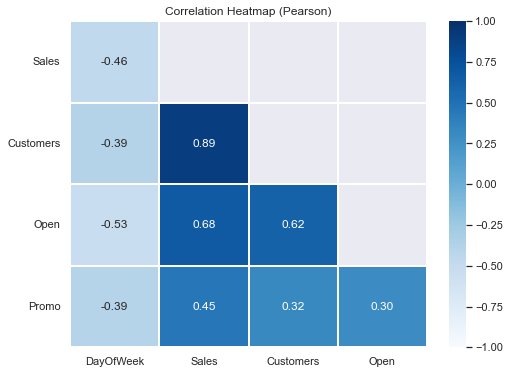

In [34]:
fig, ax = plt.subplots(figsize = (8, 6))
mask = np.triu(np.ones_like(df4.corr(), dtype = np.bool_))[1:, :-1]
sns.heatmap(df4.corr().iloc[1:,:-1], vmin = -1, vmax = 1, cmap = 'Blues', annot = True, fmt = ".2f", linewidth = 0.3, mask = mask)
ax.set_title('Correlation Heatmap (Pearson)')
plt.yticks(rotation = 0)

From the above heatmap, we can see clearly that the strongest correlation using the Pearson product-moment correlation coefficient metric is the pair `Customers` and `Sales`. `Open` and `Promo` also have strong correlations with `Sales`.

In [35]:
df4.corr(method = 'spearman')

,DayOfWeek,Sales,Customers,Open,Promo
DayOfWeek,1.000000,-0.450717,-0.430877,-0.528344,-0.392785
Sales,-0.450717,1.000000,0.903353,0.652013,0.489565
Customers,-0.430877,0.903353,1.000000,0.652015,0.377257
Open,-0.528344,0.652013,0.652015,1.000000,0.295042
Promo,-0.392785,0.489565,0.377257,0.295042,1.000000


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Sales'),
  Text(0, 1.5, 'Customers'),
  Text(0, 2.5, 'Open'),
  Text(0, 3.5, 'Promo')])

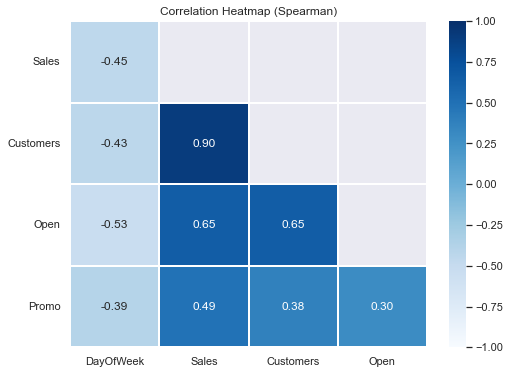

In [36]:
fig, ax = plt.subplots(figsize = (8, 6))
mask = np.triu(np.ones_like(df4.corr(method = 'spearman'), dtype = np.bool_))[1:, :-1]
sns.heatmap(df4.corr(method = 'spearman').iloc[1:,:-1], vmin = -1, vmax = 1, cmap = 'Blues', annot = True, fmt = ".2f", linewidth = 0.3, mask = mask)
ax.set_title('Correlation Heatmap (Spearman)')
plt.yticks(rotation = 0)

Comparing with the correlation matrix using the Spearman's rank correlation coefficient metric, it is about the same as the correlation matrix using the Pearson product-moment correlation coefficient metric. The difference in precision is about 0.01.

## **Section 6: Permutation Testing (Q6)**

In this section, three single-variable regression models will be built with three permutation tests to observe if the predictions on sales based on the regression models are better than chance. The three variables are one likely good, one presumably meaningless, and one at random. Because the regression models only contain one variable, I used simple linear regression to build the models. Moreover, `sklearn.model_selection.permutation_test_score` is a convenient function to perform permutation tests with p-values returned. Root Mean Squared Logarithmic Error (RMSLE) will be used as the statistic to score the models. $\text{RMSLE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\ln{(1 + y_i)}-\ln{(1+\hat{y}_i}))^2}$, where $y_i$ denotes the true sales of the $i$-th store on a single day and $\hat{y}_i$ denotes the corresponding predicted value.

Note that currently since no scoring parameter corresponds to RMSLE in scikit-learn, it is necessary to make a scorer from an existing performance metric. The closest metric is `sklearn.metrics.mean_squared_log_error`. Also, remark from the below description that the internal scoring strategy in the permutation function is maximizing the score function. On the other hand, the rank statistic used here is an error function, which should be minimized. We need to negate the value of the metric in the permutation function because minimizing RMSLE is equivalent to maximizing -RMSLE.

> **sklearn.model_selection.permutation_test_score(estimator, X, y, *, groups=None, cv=None, n_permutations=100, n_jobs=None, random_state=0, verbose=0, scoring=None, fit_params=None)**
>
> Evaluate the significance of a cross-validated score with permutations.
>
> Permutes targets to generate ‘randomized data’ and compute the empirical p-value against the null hypothesis that features and targets are independent.
>
> The p-value represents the fraction of randomized data sets where the estimator performed as well or better than in the original data. A small p-value suggests that there is a real dependency between features and targets which has been used by the estimator to give good predictions. A large p-value may be due to lack of real dependency between features and targets or the estimator was not able to use the dependency to give good predictions.

In [37]:
linreg = LinearRegression()
df5 = df[['Sales', 'Customers']]
X1 = df5['Customers']
y1 = df5['Sales']

neg_root_mean_squared_log_error = make_scorer(mean_squared_log_error, greater_is_better = False, squared = False)
permutation_test_score(linreg, X1.values.reshape(-1, 1), y1, scoring = neg_root_mean_squared_log_error, random_state = 123)[2]

0.009900990099009901

I chose `Customers` for the likely good feature. At the 5% level of significance, the p-value is less than 0.05. Thus, we reject the null hypothesis that `Customers` and `Sales` are independent. That is, there is a real dependency between `Customers` and `Sales` which has been used by the estimator to give good predictions.

In [38]:
df6 = df[['Sales', 'CompetitionDistance']]
df6.dropna(how = 'any', inplace = True)
X2 = df6['CompetitionDistance']
y2 = df6['Sales']

permutation_test_score(linreg, X2.values.reshape(-1, 1), y2, scoring = neg_root_mean_squared_log_error, random_state = 123)[2]

1.0

I selected `CompetitionDistance` for the possibly useless feature. At the 5% level of significance, the p-value is larger than 0.05. Thus, we fail to reject the null hypothesis that `CompetitionDistance` and `Sales` are independent. That is, there is a lack of real dependency between `CompetitionDistance` and `Sales` or the estimator was not able to use the dependency to give good predictions.

In [39]:
np.random.seed(123)
np.random.choice(train.columns.delete(2))

'StateHoliday'

In [40]:
df7 = df[['Sales', 'StateHoliday']]
df7['StateHoliday'].replace(['a', 'b', 'c'], 1, inplace = True)
X3 = df7['StateHoliday']
y3 = df7['Sales']

permutation_test_score(linreg, X3.values.reshape(-1, 1), y3, scoring = neg_root_mean_squared_log_error, random_state = 123)[2]

0.009900990099009901

Finally, the randomly selected variable is `StateHoliday`. `Date` is excluded from the sampling process because it is not a meaningful variable to be regressed on unless different variables are created to store the pieces of information of `Date`. At the 5% level of significance, the p-value is less than 0.05. Thus, we reject the null hypothesis that `StateHoliday` and `Sales` are independent. That is, there is a real dependency between `StateHoliday` and `Sales` which has been used by the estimator to give good predictions.

## **Section 7: Interesting findings (Q7)**

Besides the information obtained from the previous analysis, there are additional interesting findings that can be revealed by visualizations. I listed five more observations based on personal judgment.

[Text(0.5, 0, 'Sales in Millions')]

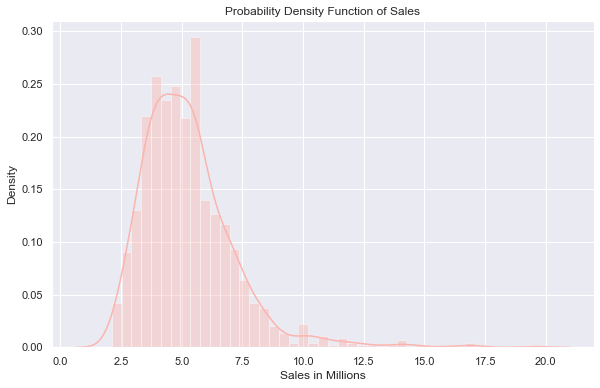

In [41]:
grouped13 = df.groupby('Store')['Sales'].sum()/1000000

fig, ax = plt.subplots(figsize = (9.7, 6))
sns.distplot(grouped13)
ax.set_title('Probability Density Function of Sales')
ax.set(xlabel = 'Sales in Millions')

In [Section 3(a)](#Section-3(a):-Sales-Per-Week-over-Time) and [Section 3(b)](#Section-3(b):-Patterns-of-Sales), the violin plots are not as normal as I thought based on the large sample statistical theory. In particular, the violin plots for the patterns of sales are mostly bimodally distributed rather than normally distributed. Therefore, I am interested in the distribution of sales. Based on the probability density function of the data, the distribution of `Sales` is approximately normal with some light tails on the right. Also, most stores have a sale around 5 million.

Text(0.5, 1.0, 'Sales Versus Day of Week')

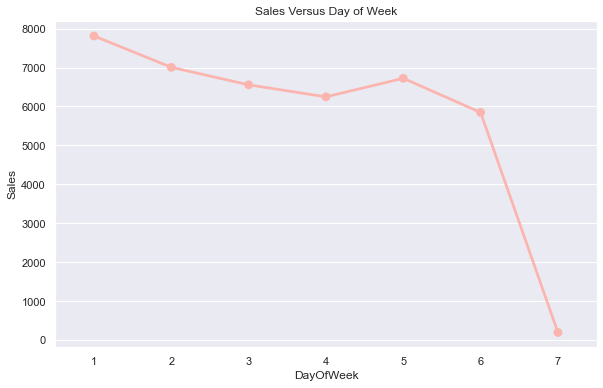

In [42]:
grouped14 = df[['DayOfWeek', 'Sales']].groupby('DayOfWeek')['Sales'].mean().reset_index()

fig, ax = plt.subplots(figsize = (9.7, 6))
sns.pointplot(x = 'DayOfWeek', y = 'Sales', data = grouped14)
ax.set_title('Sales Versus Day of Week')

I am not only interested in the distribution of sales in general, but also how many sales every day. I am curious about which day do stores have the highest sales in general. The answer is that stores have the most sales on Monday, and the least on Sunday. The average sale on Sunday is about 0, which can be explained by the fact that stores normally close on Sunday, similar to the explanation in the analysis of sales and holidays in [Section 2](#Section-2:-Effect-of-Holidays-(Q2)). Furthermore, I propose that Monday has the highest sales due to the closing on Sunday, and Friday the second due to the weekend after.

Text(0.5, 1.0, 'Sales Versus Month of Year')

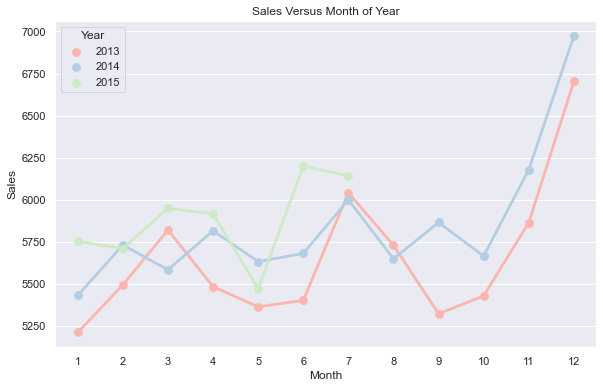

In [43]:
grouped15 = df[['Sales', 'Year', 'Month']].groupby([df['Year'], df['Month']])['Sales'].mean().reset_index()

fig, ax = plt.subplots(figsize = (9.7, 6))
sns.pointplot(x = 'Month', y = 'Sales', hue = 'Year', data = grouped15)
ax.set_title('Sales Versus Month of Year')

After analyzing the sales for each day in a week, it is reasonable to investigate which month yields the highest sales. Note that there are only six months of data in 2015. However, the sales drastically go up starting in October and ending in December. The sales go back to the lowest level in January. I believe that the significant increase in sales from October to December is due to the coming winter and Christmas. Moreover, summer holidays for students may be the factor of the sudden increase in sales in July. Last but not least, the lowest sales in January may suggest the shopping break after the shopping season.

Text(0.5, 1.0, 'Sales Versus Customers')

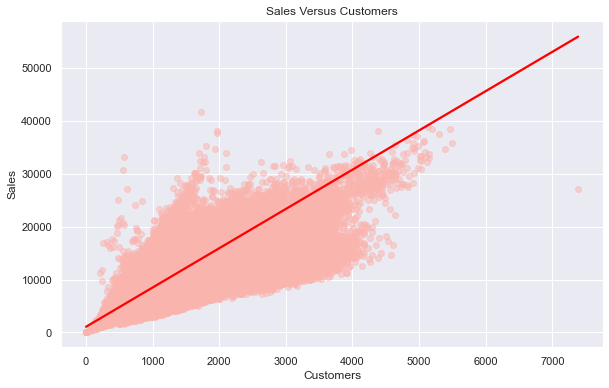

In [44]:
df8 = df[['Sales', 'Customers']]

fig, ax = plt.subplots(figsize = (9.7, 6))
sns.regplot(x = 'Customers', y = 'Sales', data = df8, scatter_kws = {'alpha': 0.5}, line_kws = {"color": "red"})
ax.set_title('Sales Versus Customers')

Sometimes I observe that luxury stores, in general, do not have a lot of customers in a given time frame. Therefore, I wonder if the number of customers can affect the sales. Based on the scatterplot above, there is a strong positive relationship between the number of customers and sales, as ready showed in the correlation heatmap in [Section 5](#Section-5:-Pearson-Correlation-of-Features-(Q5)). The interesting property I want to discuss in the visualization is the outlier on the right. I am curious about the store information corresponding to that outlier. For example, what kind of store would there be a lot of customers, but not that many sales, comparatively speaking. Also, there is a chance that the outlier exists because the information is wrongly entered. Hence, additional investigation on that outlier is required.

Text(0.5, 1.0, 'Sales Versus Store Type')

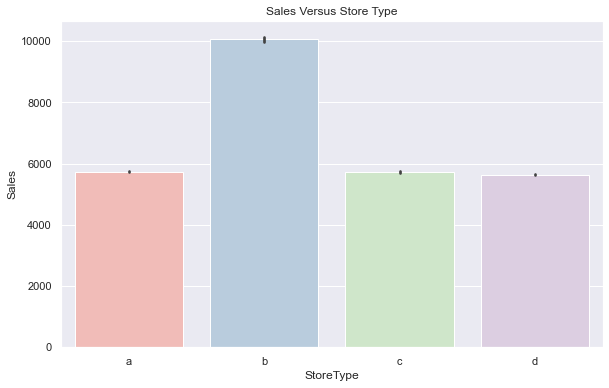

In [45]:
df9 = df[['Sales', 'StoreType']]

fig, ax = plt.subplots(figsize = (9.7, 6))
sns.barplot(x = 'StoreType', y = 'Sales', data = df9, order = ['a', 'b', 'c', 'd'])
ax.set_title('Sales Versus Store Type')

In the previous graph, I thought about whether different kinds of stores can impact sales. There is a variable `StoreType` that provides additional information about the types of stores.

> `StoreType` - differentiates between 4 different store models: a, b, c, d

From the bar chart, store Type b has the highest sales, much higher than the rest. There is not a significant difference in sales among store Types a, c and d.

## **Section 8: Train Test Split and Modelling (Q8)**

To begin with this task, I first selected some variables that can help predict sales based on my judgment in the previous tasks. The variables are `DayOfWeek`, `Customers`, `Open`, `Promo`, `StateHoliday` and `SchoolHoliday`.

In [46]:
df10_X = train[['DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']]
df10_X['StateHoliday'].replace(['a', 'b', 'c'], 1, inplace = True)
df10_y = train['Sales']
df10_X.isnull().sum()

DayOfWeek        0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

It is a better idea to reduce the number of features for training models to predict `Sales`. I used `SelectKBest`, a univariate feature selection method, to choose only the $k$ highest scoring features. The scoring function used to evaluate the features is the sample's ANOVA F-value. I am interested in training four features.

In [47]:
test = SelectKBest(score_func = f_classif, k = 4)
fit = test.fit(df10_X, df10_y)
np.set_printoptions(precision = 2, suppress = True)
fit.scores_

array([    21.95,    220.96, 121677.29,     15.99,      7.85,      1.55])

The top four scoring features are `DayOfWeek`, `Customers`, `Open` and `Promo`. Next, we can split the dataset into a training and a validation set. For this task, The validation set will contain all the data from May, June, and July of 2015, and the training set will
have of the rest of the data. For the following two models, some combinations of hyperparameters will be tried and see if those lead to a better model. The evaluation statistic used is the Root Mean Square Percentage Error (RMSPE) given by $\text{RMSPE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(\frac{y_i-\hat{y}_i}{y_i}\right)^2}$, where $y_i$ denotes the true sales of the $i$-th store on a single day and $\hat{y}_i$ denotes the corresponding predicted value. Remark that the denominator in the above equation cannot be 0, and hence any day and store with 0 sales is ignored in scoring.

In [48]:
train['Year'] = train.Date.map(lambda x: x.year)
train['Month'] = train.Date.map(lambda x: x.month)

X_train = train[['DayOfWeek', 'Customers', 'Open', 'Promo']][~((train['Year'] == 2015) & (train['Month'].isin([5, 6, 7])))]
y_train = pd.DataFrame(train['Sales'][~((train['Year'] == 2015) & (train['Month'].isin([5, 6, 7])))], columns = ['Sales'])
X_test = train[['DayOfWeek', 'Customers', 'Open', 'Promo']][(train['Year'] == 2015) & (train['Month'].isin([5, 6, 7]))]
y_test = pd.DataFrame(train['Sales'][(train['Year'] == 2015) & (train['Month'].isin([5, 6, 7]))], columns = ['Sales'])

### Section 8(a): Decision Tree

I selected the decision tree algorithm to train the first prediction model.

> **sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)**

In [49]:
model_1a = DecisionTreeRegressor(random_state = 123)
model_1a.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

The first set of hyperparameters I chose is the default, except for `random_state`, which is used to reproduce results.

In [50]:
start = time.process_time()
model_1a.fit(X_train, y_train)
time.process_time() - start

0.78125

I also timed the training process for the default hyperparameters for the comparison of performance later on.

In [51]:
y_predict1a = pd.DataFrame(model_1a.predict(X_test), index = y_test.index, columns = ['SalesPredicted'])
df11a = y_test.join(pd.DataFrame(y_predict1a))
df11a.drop(df11a[df11a['Sales'] == 0].index, inplace = True)
np.sqrt(np.mean(np.square(((df11a['Sales'] - df11a['SalesPredicted']) / df11a['Sales']))))

0.20494901856093314

The RMSPE for the default hyperparameters is about 0.205.

In [52]:
model_1b = DecisionTreeRegressor(min_samples_split = 5, min_samples_leaf = 2, random_state = 123)
start = time.process_time()
model_1b.fit(X_train, y_train)
time.process_time() - start

0.78125

The second set of hyperparameters considers a different value for `min_samples_split` and `min_samples_leaf`. The default settings for the two hyperparameters are 2 and 1, respectively.

In [53]:
y_predict1b = pd.DataFrame(model_1b.predict(X_test), index = y_test.index, columns = ['SalesPredicted'])
df11b = y_test.join(pd.DataFrame(y_predict1b))
df11b.drop(df11b[df11b['Sales'] == 0].index, inplace = True)
np.sqrt(np.mean(np.square(((df11b['Sales'] - df11b['SalesPredicted']) / df11b['Sales']))))

0.20382304141342591

In [54]:
model_1c = DecisionTreeRegressor(min_samples_split = 10, min_samples_leaf = 4, random_state = 123)
start = time.process_time()
model_1c.fit(X_train, y_train)
time.process_time() - start

0.796875

The last set of hyperparameters considers another pair of `min_samples_split` and `min_samples_leaf` to confirm whether the increasing values of the two hyperparameters can decrease the RMSPE.

In [55]:
y_predict1c = pd.DataFrame(model_1c.predict(X_test), index = y_test.index, columns = ['SalesPredicted'])
df11c = y_test.join(pd.DataFrame(y_predict1c))
df11c.drop(df11c[df11c['Sales'] == 0].index, inplace = True)
np.sqrt(np.mean(np.square(((df11c['Sales'] - df11c['SalesPredicted']) / df11c['Sales']))))

0.20302009496053333

Below is a summary table for the three hyperparameter settings in the decision tree model with their respective RMSPE and timing performance. The third model with hyperparameters `min_samples_split` = 10 and `min_samples_leaf` = 4 gives the best performance because it has a slightly lower RMSPE.

|   Model  | RMSPE  |  Time   |
|:---------:|:------:|:--------:|
| Model 1a  | 0.2049 | 0.781 s  |
| Model 1b  | 0.2038 | 0.781 s  |
| Model 1c  | 0.2030 | 0.797 s  |

### Section 8(b): Random Forest

The next model will be trained by the random forest algorithm.

> **sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)**

In [56]:
model_2a = RandomForestRegressor(random_state = 123)
model_2a.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

Again, I used the default hyperparameters, except for `random_state`, to train the model at the beginning.

In [57]:
start = time.process_time()
model_2a.fit(X_train, y_train)
time.process_time() - start

70.046875

In [58]:
y_predict2a = pd.DataFrame(model_2a.predict(X_test), index = y_test.index, columns = ['SalesPredicted'])
df12a = y_test.join(pd.DataFrame(y_predict2a))
df12a.drop(df12a[df12a['Sales'] == 0].index, inplace = True)
np.sqrt(np.mean(np.square(((df12a['Sales'] - df12a['SalesPredicted']) / df12a['Sales']))))

0.20338451589409137

In [59]:
model_2b = RandomForestRegressor(n_estimators = 10, random_state = 123)
start = time.process_time()
model_2b.fit(X_train, y_train)
time.process_time() - start

7.03125

The second set of hyperparameters considers `n_estimator` = 10. The default value for `n_estimator` is 100.

In [60]:
y_predict2b = pd.DataFrame(model_2b.predict(X_test), index = y_test.index, columns = ['SalesPredicted'])
df12b = y_test.join(pd.DataFrame(y_predict2b))
df12b.drop(df12b[df12b['Sales'] == 0].index, inplace = True)
np.sqrt(np.mean(np.square(((df12b['Sales'] - df12b['SalesPredicted']) / df12b['Sales']))))

0.20380734668436284

In [61]:
model_2c = RandomForestRegressor(min_samples_split = 10, min_samples_leaf = 4, random_state = 123)
start = time.process_time()
model_2c.fit(X_train, y_train)
time.process_time() - start

72.09375

The last set of hyperparameters considers a different value for `min_samples_split` and `min_samples_leaf`. The default settings for the two hyperparameters are 2 and 1, respectively.

In [62]:
y_predict2c = pd.DataFrame(model_2c.predict(X_test), index = y_test.index, columns = ['SalesPredicted'])
df12c = y_test.join(pd.DataFrame(y_predict2c))
df12c.drop(df12c[df12c['Sales'] == 0].index, inplace = True)
np.sqrt(np.mean(np.square(((df12c['Sales'] - df12c['SalesPredicted']) / df12c['Sales']))))

0.2020887637961826

Below is a summary table for the three hyperparameter settings in the random forest model with their respective RMSPE and timing performance. The third model with hyperparameters `min_samples_split` = 10 and `min_samples_leaf` = 4 gives the best RMSPE, but the time is much longer than the decision tree algorithms. On the other hand, Model 2b has a better time, but still, RMSPE is slightly higher than Model 1c.

|  Model   | RMSPE  |  Time    |
|:---------:|:------:|:---------:|
| Model 2a  | 0.2034 | 70.047 s  |
| Model 2b  | 0.2038 | 7.0313 s  |
| Model 2c  | 0.2021 | 72.094 s  |

## **Section 9: t-test (Q9)**

After we obtained the better models by tuning hyperparameters in the two algorithms above, we may want to test whether the difference of their predictions is statistically significant. In this case, performing a t-test is the best way to verify that. Remark that the two independent samples t-test requires to know if the variances of the two populations are the same. Thus, we need to test the equal-variance assumption for the two populations using Levene's test. To obtain a robust result, we have to select the best case among the three possible variations in Levene's test depending on the population distributions.

> **scipy.stats.levene(*args, center='median', proportiontocut=0.05)**
>
> **scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)**

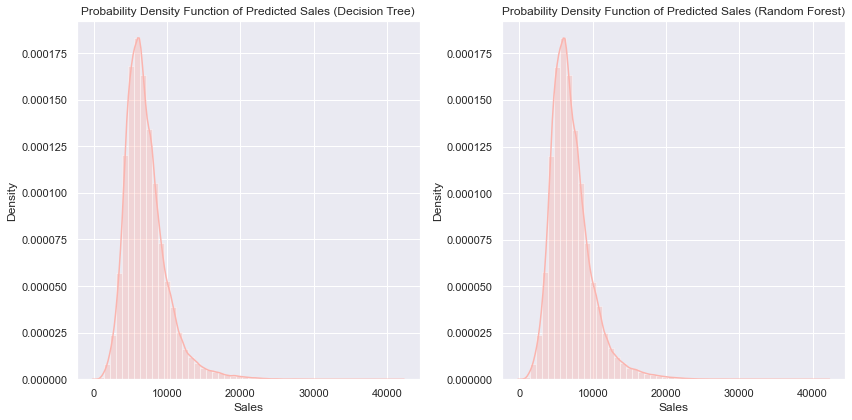

In [63]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.distplot(df11c, ax = ax[0])
ax[0].set_title('Probability Density Function of Predicted Sales (Decision Tree)')
ax[0].set(xlabel = 'Sales')

sns.distplot(df12c, ax = ax[1])
ax[1].set_title('Probability Density Function of Predicted Sales (Random Forest)')
ax[1].set(xlabel = 'Sales')

plt.tight_layout()

Based on the above probability density functions, the predicted sales using the two algorithms are approximately normal with a small tail on the right. Therefore, the default setting `center='median'` is appropriate in Levene's test.

In [64]:
levene(df11c['SalesPredicted'], df12c['SalesPredicted']).pvalue

0.9896237453454815

At the 5% level of significance, since the p-value is greater than 0.05, we fail to reject the null hypothesis that all input samples are from populations with equal variances. That is, we can assume an equal-variance assumption in the t-test below.

In [65]:
ttest_ind(df11c['SalesPredicted'], df12c['SalesPredicted']).pvalue

0.9887736509097695

At the 5% level of significance, since the p-value is greater than 0.05, we fail to reject the null hypothesis that the two independent samples have identical average (expected) values. That is, we are 95% confident that the two predictions are not significantly different.

## **Section 10: Screenshots (Q10)** 

Lastly, we want to use the two prediction models built above to obtain a prediction for the observations in the testing set. Note that we have to make sure no missing values are present in the testing data so that we can move on to the prediction.

In [66]:
test = pd.read_csv('rossmann-store-sales/test.csv')
result = test['Id']
X_test_1 = test[['Store', 'DayOfWeek', 'Open', 'Promo']]
X_test_1.isnull().sum()

Store         0
DayOfWeek     0
Open         11
Promo         0
dtype: int64

There are 11 missing values for `Open`. Because the number of missing values is small (0.035%), I will use random value imputation based on the distribution of `Open` data values.

In [67]:
np.random.seed(123)
X_test_1['Open'].fillna(np.random.choice((0, 1), 1, p = [0.125, 0.875])[0], inplace = True)
grouped16 = train[['Store', 'DayOfWeek', 'Customers']].groupby(['Store', 'DayOfWeek']).mean()
X_test_1 = pd.merge(X_test_1, grouped16, on = ['Store', 'DayOfWeek'])
X_test_1 = X_test_1.drop('Store', 1)
X_test_1 = X_test_1[['DayOfWeek', 'Customers', 'Open', 'Promo']]

y_predict_test_1 = model_1c.predict(X_test_1)
result_1 = pd.concat([result, pd.DataFrame(y_predict_test_1, columns = ['Sales'])], axis = 1)
result_1.to_csv('model_1.csv', index = False)

y_predict_test_2 = model_2c.predict(X_test_1)
result_2 = pd.concat([result, pd.DataFrame(y_predict_test_2, columns = ['Sales'])], axis = 1)
result_2.to_csv('model_2.csv', index = False)

Public Score: 0.72378

Private Score: 0.70639

Kaggle profile link: https://www.kaggle.com/garylikai

Screenshot(s): ![Screenshot](Kaggle_Challenge.png)